# One-cell model

This model describes a single cell with extracellular space (apoplast) on two sides and further is a closed system. Components are auxin, auxin efflux carrier (PIN) , auxin influx carrier (AUX) and auxin binding protein (ABP).    
  
![ABPonecell](/home/felix/Desktop/ABPonecell.png)

### Hypothesis:
### With only the flux between the cell and it's neighbouring apoplasts, the system should be bistable with two stable and one instable steady state, either if there is an asymmetry between the sides or not.

In [668]:
import sys
import numpy as np
import pylab as plt
from scipy.interpolate import spline
from matplotlib import ticker as tick
%matplotlib inline
import random
from matplotlib import animation
from IPython.display import HTML
from assimulo.solvers import CVode
from assimulo.problem import Explicit_Problem

In [707]:
class ABP1C():
    def __init__(self,PBC):
        
        self.T=[1]
        self.verb=50
        self.pbc=PBC
        self.LRratio=0
        
        # parameter
        self.para={
            "Asyn":1,
            "Abase":1,
            "Apin":1,
            "Ain":1,
            "Acdiff":1,
            "Aout":1,
            "Psyn":1,
            "PINbase":1,
            "Pin":1,
            "Pex":1,
            "B_Vmax":1,
            "B_Km":1,
            "ABPr":1,
            "ABPreg":1
        }

        
    # show integration time progress    
    def progress(self,t,T=0):
        T=self.T[0]
        prog="\r{0:.4f}%".format(t/T*100)
        sys.stdout.write(prog+" "*(25-len(prog)))
    
    # helper function 
    def shift(self,A,d):
        a=list(A)
        if d: 
            if self.pbc: out=np.array([a[-1]]+a[:-1])
            else: out=np.array([a[1]]+a[:-1])
        else:
            if self.pbc: out=np.array(a[1:]+[a[0]])
            else: out=np.array(a[1:]+[a[-1]])
        return out
    
    # Auxin synthesis + degration
    def v_Asyn(self,Ac):
        return self.para["Asyn"] * (self.para["Abase"] - Ac)
    
    # Auxin degration in apoplast
    def v_Aadeg(self,Aa):
        return self.para["Aadeg"]*Aa
    
    # PIN-mediated auxin transport (cell efflux)
    def v_Apin(self,Ac,P):
        return self.para["Apin"] * Ac * P
    
    # AUX-mediated auxin transport (cell influx)
    def v_Ain(self,Aa):
        return self.para["Ain"] * Aa
    
    # auxin diffusion
    def v_Adiff(self,A0,A1,out=0):
        for i in A1:
            out += self.para["Acdiff"] * (A0 - i)
        return out
            
    # ABP/Auxin association (Aa + ABPub -> ABPb) 
    def v_Abind(self,A0,L,ABPb):
        B = self.para["B_Vmax"] * L * A0 / (self.para["B_Km"] + L) 
        R = self.para["ABPr"] * ABPb
        return R-B
    
    # apoplast efflux
    
    #Pin synthesis
    def v_Psyn(self,Pt):
        return self.para["Psyn"] * (self.para["Pbase"] - Pt)
    
    # PIN endocytosis
    def v_Pin(self,P,out=0):
        for p in P:
            out += self.para["Pin"] * p[0] * (1 + self.para["ABPreg"] * p[1])
        return out
    
    # PIN exocytosis
    def v_Pex(self,P0): #P0=Pt-Pm
        return self.para["Pex"] * P0
    
    # apoplast efflux
    def v_out(self,Aa):
        return self.para["Aout"] * Aa
    
    # ODE 
    def sim(self,time,start):

        Ac,AaL,AaR,Pi,PL,PR,ABPubL,ABPubR,ABPbL,ABPbR=start       

        
        dAc = self.v_Asyn(Ac) - self.v_Apin(Ac,PL+PR) + self.v_Ain(AaL+AaR) - self.v_Adiff(Ac,[AaL,AaR])
        dAaL = self.v_Apin(Ac,PL) - self.v_Ain(AaL) - self.v_Adiff(AaL,[Ac]) + self.v_Abind(AaL,ABPubL,ABPbL) - self.v_out(AaL) 
        dAaR = self.v_Apin(Ac,PR) - self.v_Ain(AaR) - self.v_Adiff(AaR,[Ac]) + self.v_Abind(AaR,ABPubR,ABPbR) - self.v_out(AaR)
        
        dPi = self.v_Psyn(Pi+PL+PR) - self.v_Pex(Pi) + self.v_Pin([[PL,ABPubL],[PR,ABPubR]])
        dPL = self.v_Pex(Pi)*(1+self.LRratio) - self.v_Pin([[PL,ABPubL]])
        dPR = 0#self.v_Pex(Pi)*(1-self.LRratio) - self.v_Pin([[PR,ABPubR]])

        dABPubL = self.v_Abind(AaL,ABPubL,ABPbL)
        dABPubR = self.v_Abind(AaR,ABPubR,ABPbR)
        dABPbL = - self.v_Abind(AaL,ABPubL,ABPbL) 
        dABPbR = - self.v_Abind(AaR,ABPubR,ABPbR) 

        return [dAc,dAaL,dAaR,dPi,dPL,dPR,dABPubL,dABPubR,dABPbL,dABPbR]
    
    def intgr(self,time,start):
        self.T[0]=time
        
        # CVode from Assimulo                
        problem=Explicit_Problem(self.sim,start)
        sim=CVode(problem)
        sim.verbosity=self.verb
        T,res=sim.simulate(time,time)

        return [T,res]    

### "Find the steady state"-function

In [595]:
def get_stdy(line,acc=1e-3,wsize=500,steps=10):
    start=0
    while np.std(line[start:start+wsize])>acc:
        start+=steps
    return start

### "Make auxin net efflux manually asynchronous"-function

In [677]:
def sidecheck():
    lnp=np.linspace(-0.5,0.5,10)
    out=np.zeros((len(lnp),5))
    for i,n in enumerate(lnp):
        model.LRratio=n
        T,R=model.intgr(time,start)
        out[i,:4]=R[-1,[1,2,4,5]]
        out[i,4]=n
    return out

def sc_plot():
    out=sidecheck()
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    Lab=["AaL","AaR","PinL","PinR"]
    [ax.plot(out[:,-1],out[:,i],label=Lab[i]) for i in range(4)]
    ax.set_xlabel="LRratio"
    ax.set_ylabel="concentration"
    ax.legend()
    plt.show()

## "System-wide view"-plot function

In [619]:
%matplotlib inline

def systemplot():
    # component labels
    lab=["Ac","AaL","AaR","Pi","PL","PR","ABPubL","ABPubR","ABPbL","ABPbR"]

    fig,ax=plt.subplots(figsize=(15,8))
    bw=0.2
    col1=["deepskyblue","orchid","m"]
    lab1=["auxin (apoplast)","unbound ABP","bound ABP"]

    col2=["lightblue","lightsalmon"]
    lab2=["auxin (cytosol)","inactive PIN"]

    #left
    for i,n in enumerate([1,6]):
        ax.bar(-0.1+i*bw,R[-1,n],width=bw,color=col1[i])
    ax.bar(0.1,R[-1,8],width=bw,color=col1[2],bottom=R[-1,6])

    #left mem
    ax.bar(1,R[-1,4],width=bw,color="tomato")

    #mid
    for i,n in enumerate([0,3]):
        ax.bar(1.9+i*bw,R[-1,n],width=bw,label=lab2[i],color=col2[i])

    #right mem
    ax.bar(3,R[-1,5],width=bw,label="PIN (membrane)",color="tomato")

    #right
    for i,n in enumerate([2,7]):
        ax.bar(3.9+i*bw,R[-1,n],width=bw,label=lab1[i],color=col1[i])
    ax.bar(4.1,R[-1,9],width=bw,label=lab1[2],color=col1[2],bottom=R[-1,7])

    [ax.axvline(i,color="k",ls="--") for i in [0.6,3.4]]

    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(["left apoplast","left membrane","cytosol","right membrane","right apoplast"])

    ax.set_title("left apoplast  ||  cell  ||  right apoplast")
    ax.set_ylim(0,)
    ax.set_ylabel("concentration")
    ax.yaxis.grid(alpha=0.5)
    if sum(show_val1.values())>0: ax.legend(loc=1)
    plt.show()
    print("Total:")
    print("Auxin: {0:0.3f}".format(sum(R[-1,:3])))
    print("PIN: {0:0.3f}".format(sum(R[-1,3:6])))
    print("ABP: {0:0.3f}".format(sum(R[-1,-4:])),"\n")
    print("symmetry: {0:0.6f}/{1:0.6f}".format(sum(R[-1,[1,4,6,8]]),sum(R[-1,[2,5,7,9]])))

## "Time-resolved view"-plot function

In [643]:
def timeplot(show_val):
    plt.figure(figsize=(15,8))

    [plt.plot(R[:,i],label=lab[i]) for i in range(10) if show_val[lab[i]]]

    plt.title("Cell")
    plt.xlabel("time")
    plt.ylabel("concentration")
    plt.grid(alpha=0.5)
    plt.legend()

    plt.xlim((0,40000))
    #plt.ylim((0,10))

    plt.show()
    print("Compound \t steady state \t      final concentration")
    for i in range(10):
        if show_val[lab[i]]: 
            std=get_stdy(R[:,i].T)
            print(lab[i],"\t\t",std,"\t\t","{:10.3f}".format(R[std,i]))
        
    

0.0027500000000000003


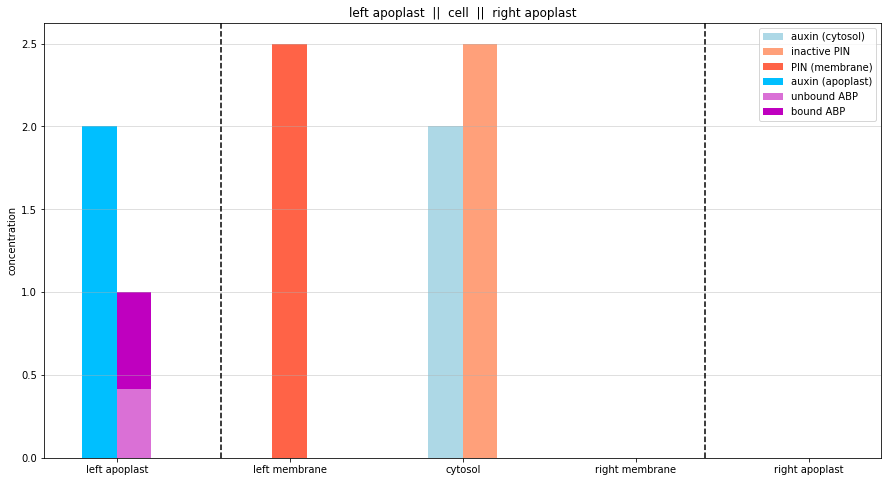

Total:
Auxin: 4.000
PIN: 5.000
ABP: 1.000 

symmetry: 5.499995/0.000000


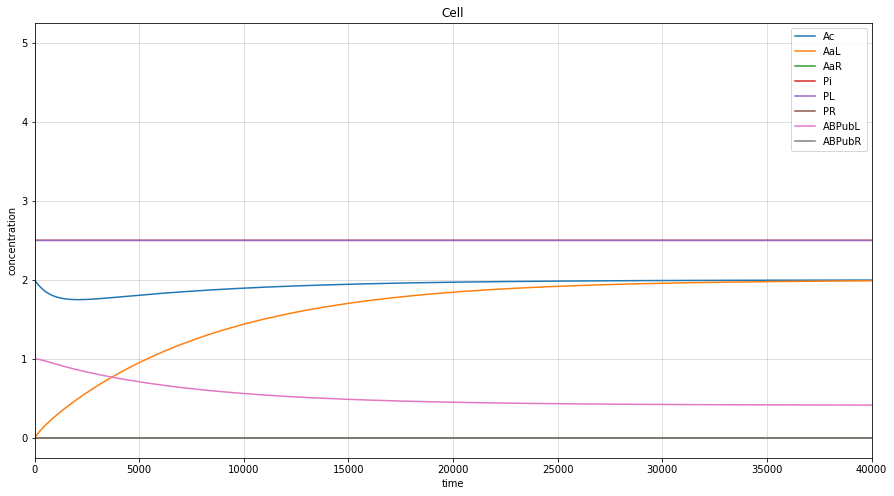

Compound 	 steady state 	      final concentration
Ac 		 1700 		      1.754
AaL 		 28020 		      1.945
AaR 		 0 		      0.000
Pi 		 20 		      2.501
PL 		 20 		      2.499
PR 		 0 		      0.000
ABPubL 		 17550 		      0.467
ABPubR 		 0 		      0.000
[1.99999908e+00 1.99999506e+00 1.22790977e-21 2.50000000e+00
 2.50000000e+00 1.59629617e-21 4.14173726e-01 0.00000000e+00
 5.85826274e-01 0.00000000e+00]


In [717]:
# initial condition

# Initial concentrations (order of components)
# [Auxin_cyt, Auxin_left, Auxin_right,
#  PIN_inside, PIN left, PIN_right,
#  ABPub_left, ABPub_right, ABPb_left, ABPb_right]

comp=[2,0,0,
      4,0,0,
      1,0,0,0]

# model input:
start=comp

# manual manipulation of initial concentration(s):

# which concentration(s) 
p=8

# change
start[p]*=1

time=100000

# periodic binding condition 
PBC=0

# class initiation
model=ABP1C(PBC)

# model parameter
# Auxin:
model.para["Asyn"]=0.001
model.para["Abase"]=2
model.para["Apin"]=0.00008
model.para["Ain"]=0.0002#model.para["Apin"]
model.para["Acdiff"]=0.0
model.para["Aout"]=0.0

# PIN:
model.para["Psyn"]=0.00
model.para["Pbase"]=2
model.para["Pin"]=0.2#
model.para["Pex"]=0.2#model.para["Pin"]

# ABP
model.para["B_Vmax"]=0.001
model.para["B_Km"]=0.1
model.para["ABPr"]=model.para["B_Vmax"]/model.para["B_Km"]*0.275
model.para["ABPreg"]=0.0
print(model.para["ABPr"])
# integration

#R=model.sim(time,start)
T,R=model.intgr(time,start)

systemplot()

show_val={"Ac":1,
          "AaL":1,
          "AaR":1,
          "Pi":1,
          "PL":1,
          "PR":1,
          "ABPubL":1,
          "ABPubR":1,
          "ABPbL":0,
          "ABPbR":0}

timeplot(show_val)
#sc_plot()
print(R[-1])

# System-wide Auxin distribution

In [687]:
#%matplotlib notebook
import k3d
import numpy as np


xmin, xmax = -10, 10
ymin, ymax = -10, 10 

x = range(xmin, xmax)#np.linspace(xmin, xmax, Nx)
y = range(ymin, ymax)#np.linspace(ymin, ymax, Ny)
x, y = np.meshgrid(x, y)
z = np.sin(x)+np.sin(y)

plot = k3d.plot()
plt_surface = k3d.surface(z.astype(np.float32), bounds=[xmin,xmax,ymin,ymax])
plot += plt_surface
plot.display()

Output()

In [232]:
z = R[1:101,::10]
print(z)

[[4.99700097 4.99700097 4.99700097 ... 4.99700097 4.99700097 4.99700097]
 [4.99400372 4.99400372 4.99400372 ... 4.99400372 4.99400372 4.99400372]
 [4.99100826 4.99100826 4.99100826 ... 4.99100826 4.99100826 4.99100826]
 ...
 [4.71446473 4.71446473 4.71446473 ... 4.71446473 4.71446473 4.71446473]
 [4.71163663 4.71163663 4.71163663 ... 4.71163663 4.71163663 4.71163663]
 [4.70881024 4.70881024 4.70881024 ... 4.70881024 4.70881024 4.70881024]]


In [174]:
def adjust(param,change,N):
    initS=get_stdy(model.intgr(time,start)[1][:,N])
    initP=model.para[param]
    STDY=-10
    while abs(STDY-initS)>10:
        initP+=change
        model.para[param]=p
        STDY=get_stdy(model.intgr(time,start)[1][:,N])
        print(initS,initP,STDY)
    return initP

adjust("Pin",0.005,3)

950 0.005 950


0.005